# Intro to Stats, or Intro 1 / $\mathbb P(\mbox{two heads out of two tosses})$

---

References:
* https://en.wikipedia.org/wiki/P-value#Example
* https://en.wikipedia.org/wiki/Checking_whether_a_coin_is_fair
* https://en.wikipedia.org/wiki/Test_statistic

In [1]:
from typing import Callable

import numpy as np
from scipy.special import binom

from matplotlib import pyplot as plt

%matplotlib inline
%config Completer.use_jedi = False

In [2]:
plt.rcParams['font.size'] = 22

## Coin

Последовательность i.i.d. случайных величин:
$$
  X_1, \ldots, X_n\quad X_i \sim Be(p)
$$

Функция вероятности:
$$
  f(x_1, \ldots, x_n \mid p) = p^{\sum_{i=1}^n x_i} (1 - p)^{n - \sum_{i=1}^n x_i}
$$

In [3]:
np.random.seed(42)
NUM_TOSSES = 100

X = np.random.choice([0, 1], size=NUM_TOSSES, p=[0.3, 0.7])

In [4]:
X[:20]

array([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0])

In [5]:
print(f'Решка: {len(np.where(X == 0)[0])}.')
print(f'Орёл: {len(np.where(X == 1)[0])}.')

Решка: 34.
Орёл: 66.


### $p$ = ?

Статистика:
$$
  T(X_1, \ldots, X_n) = \sum\limits_{i=1}^n X_i
$$

Функция вероятности статистики:
$$
  \mathbb P(T = k) = \binom{n}{k} p^k (1 - p)^{n - k},\quad k \in [0, n]
$$

Распределение статистики:
$$
  T \sim Bin(n, p)
$$

### Hypothesis: $p = 0.5$ ("fair coin")

In [6]:
ALPHA = 0.05

In [7]:
def generate(p):
    x = range(NUM_TOSSES + 1)
    y_f = [
        binom(NUM_TOSSES, k) * p**k * (1 - p)**(NUM_TOSSES - k)
        for k in x
    ]

    y_F = list()

    for i in range(len(y_f)):
        if len(y_F) > 0:
            prev = y_F[-1]
        else:
            prev = 0

        y_F.append(prev + y_f[i])
    
    return x, y_f, y_F

In [8]:
p = 0.5

x, y_f, y_F = generate(p)

In [9]:
np.sum(X)

66

In [10]:
(NUM_TOSSES - np.sum(X)) * 0.7 / 0.3

79.33333333333333

In [11]:
def compute_stats(x, y_f, y_F):
    stat_value = np.sum(X)
    threshold1 = stat_value
    threshold2 = len(X) - stat_value
    
    compare_bigger = lambda value, threshold: value >= threshold
    compare_less = lambda value, threshold: value <= threshold

    if stat_value >= len(X) / 2:
        compare1, compare2 = compare_bigger, compare_less
    else:
        compare1, compare2 = compare_less, compare_bigger
    
    p_value1 = _compute_one_side_p_value(
        x, y_f, threshold=threshold1, compare=compare1
    )
    p_value2 = _compute_one_side_p_value(
        x, y_f, threshold=threshold2, compare=compare2
    )
    
    # https://en.wikipedia.org/wiki/One-_and_two-tailed_tests
    # https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faq-what-are-the-differences-between-one-tailed-and-two-tailed-tests
    p_value = p_value1 + p_value2

    left_threshold, _ = _compute_threshold(x, y_f, which='left')
    right_threshold, _ = _compute_threshold(x, y_f, which='right')
    
    assert left_threshold < right_threshold

    return stat_value, p_value, left_threshold, right_threshold


def _compute_one_side_p_value(x, y_f, threshold, compare: Callable):
    return sum([yi for xi, yi in zip(x, y_f) if compare(xi, threshold)])


def _compute_threshold(x, y_f, which: str) -> int:
    if which.lower() == 'left':
        i = 0
        shift = 1
        compare = lambda value, threshold: value <= threshold
    elif which.lower() == 'right':
        i = -1
        shift = -1
        compare = lambda value, threshold: value >= threshold
    else:
        raise ValueError(which)

    threshold = x[i]
    prob = y_f[i]

    while prob < ALPHA / 2:
        i = i + shift
        threshold = x[i]

        prob = _compute_one_side_p_value(x, y_f, threshold, compare=compare)
    
    return threshold, prob

In [12]:
t_value, p_value, threshold_left, threshold_right = compute_stats(x, y_f, y_F)

In [13]:
print(f'Statistic value: {t_value}.')
print(f'P-value value: {p_value:.7f}.')
print(f'Critical statistic values: {threshold_left} and {threshold_right}.')

Statistic value: 66.
P-value value: 0.0017899.
Critical statistic values: 40 and 60.


p-value = 0.002


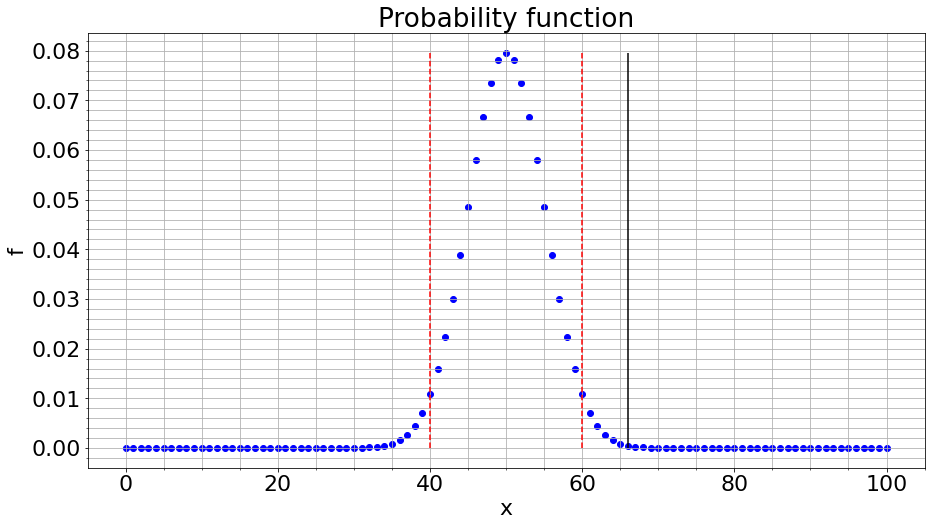

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

plt.scatter(x, y_f, color='blue')
plt.vlines(t_value, 0, max(y_f), color='k')
plt.vlines(threshold_left, 0, max(y_f), color='red', linestyle='--')
plt.vlines(threshold_right, 0, max(y_f), color='red', linestyle='--')

print(f'p-value = {p_value:.3f}')

plt.title('Probability function')
plt.xlabel('x')
plt.ylabel('f')

plt.minorticks_on()
plt.grid(which='both')

plt.show()

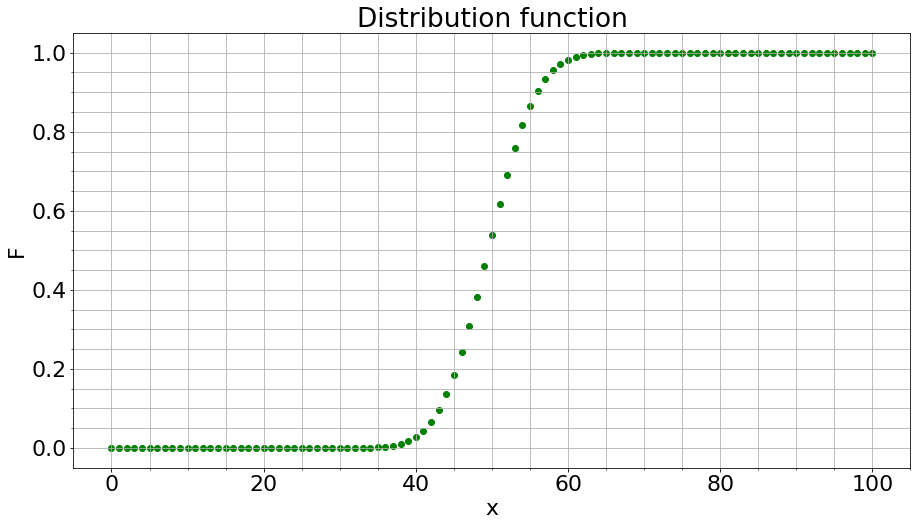

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

plt.scatter(x, y_F, color='green')

plt.title('Distribution function')
plt.xlabel('x')
plt.ylabel('F')

plt.minorticks_on()
plt.grid(which='both')

plt.show()

### Hypothesis: $p = 0.7$ ("unfair coin")

In [16]:
p = 0.7

x, y_f, y_F = generate(p)

In [17]:
t_value, p_value, threshold_left, threshold_right = compute_stats(x, y_f, y_F)

In [18]:
print(f'Statistic value: {t_value}.')
print(f'P-value value: {p_value:.7f}.')
print(f'Critical statistic values: {threshold_left} and {threshold_right}.')

Statistic value: 66.
P-value value: 0.8371417.
Critical statistic values: 61 and 79.


p-value = 0.837


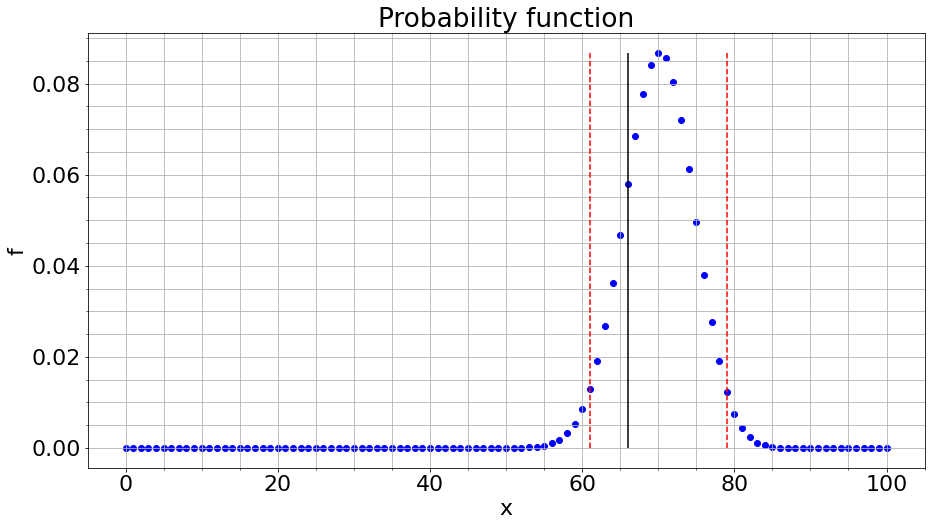

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

plt.scatter(x, y_f, color='blue')
plt.vlines(t_value, 0, max(y_f), color='k')
plt.vlines(threshold_left, 0, max(y_f), color='red', linestyle='--')
plt.vlines(threshold_right, 0, max(y_f), color='red', linestyle='--')

print(f'p-value = {p_value:.3f}')

plt.title('Probability function')
plt.xlabel('x')
plt.ylabel('f')

plt.minorticks_on()
plt.grid(which='both')

plt.show()

## Statsmodels: Getting Started

Source: https://www.statsmodels.org/stable/gettingstarted.html

In [20]:
import pandas as pd
import statsmodels.api as sm

from patsy import dmatrices

### Data

In [21]:
df = sm.datasets.get_rdataset("Guerry", "HistData").data

In [22]:
df.shape

(86, 23)

In [23]:
df.describe()

,dept,Crime_pers,Crime_prop,Literacy,Donations,Infants,Suicides,Wealth,Commerce,Clergy,Crime_parents,Infanticide,Donation_clergy,Lottery,Desertion,Instruction,Prostitutes,Distance,Area,Pop1831
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,46.883721,19754.406977,7843.058140,39.255814,7075.546512,19049.906977,36522.604651,43.500000,42.802326,43.430233,43.500000,43.511628,43.500000,43.500000,43.500000,43.127907,141.872093,207.953140,6146.988372,378.628721
std,30.426157,7504.703073,3051.352839,17.364051,5834.595216,8820.233546,31312.532649,24.969982,25.028370,24.999549,24.969982,24.948297,24.969982,24.969982,24.969982,24.799809,520.969318,109.320837,1398.246620,148.777230
min,1.000000,2199.000000,1368.000000,12.000000,1246.000000,2660.000000,3460.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,762.000000,129.100000
25%,24.250000,14156.250000,5933.000000,25.000000,3446.750000,14299.750000,15463.000000,22.250000,21.250000,22.250000,22.250000,22.250000,22.250000,22.250000,22.250000,23.250000,6.000000,121.383000,5400.750000,283.005000
50%,45.500000,18748.500000,7595.000000,38.000000,5020.000000,17141.500000,26743.500000,43.500000,42.500000,43.500000,43.500000,43.500000,43.500000,43.500000,43.500000,41.500000,33.000000,200.616000,6070.500000,346.165000
75%,66.750000,25937.500000,9182.250000,51.750000,9446.750000,22682.250000,44057.500000,64.750000,63.750000,64.750000,64.750000,64.750000,64.750000,64.750000,64.750000,64.750000,113.750000,289.670500,6816.500000,444.407500
max,200.000000,37014.000000,20235.000000,74.000000,37015.000000,62486.000000,163241.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,4744.000000,539.213000,10000.000000,989.940000


In [24]:
columns = ['Department', 'Lottery', 'Literacy', 'Wealth', 'Region']

In [25]:
df[columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Department  86 non-null     object
 1   Lottery     86 non-null     int64 
 2   Literacy    86 non-null     int64 
 3   Wealth      86 non-null     int64 
 4   Region      85 non-null     object
dtypes: int64(3), object(2)
memory usage: 3.5+ KB


In [26]:
df = df.dropna()[columns]

In [27]:
df.tail()

,Department,Lottery,Literacy,Wealth,Region
80,Vendee,68,28,56,W
81,Vienne,40,25,68,W
82,Haute-Vienne,55,13,67,C
83,Vosges,14,62,82,E
84,Yonne,51,47,30,C


In [28]:
df['Region'].nunique()

5

In [29]:
df['Region'].unique()

array(['E', 'N', 'C', 'S', 'W'], dtype=object)

### Motivation and Model

We want to know whether *literacy* rates in the 86 French departments are associated with per capita *wagers on the Royal Lottery* in the 1820s.
We need to control for the level of *wealth* in each department, and we also want to include a series of dummy variables on the right-hand side of our regression equation to control for unobserved heterogeneity due to *regional* effects:

$$
  Lottery = f(Literacy, Wealth, Region)
$$

The model is estimated using ordinary least squares regression (OLS).

### Linear Regression Model

Statistical model:
$$
  y = X \beta + \mu,\quad \mu \sim \mathcal N(0, \Sigma)
$$

$$
  \begin{pmatrix}
    y_1\\
    \vdots\\
    y_l
  \end{pmatrix}
  = \begin{pmatrix}
    1      & x_{11} & \ldots & x_{1n}\\
    1      & x_{21} & \ldots & x_{2n}\\
    \vdots & \vdots & \ddots & \vdots\\
    1      & x_{l1} & \ldots & x_{ln}
  \end{pmatrix} \begin{pmatrix}
    \beta_0\\
    \beta_1\\
    \vdots\\
    \beta_n
  \end{pmatrix}
  + \begin{pmatrix}
    \mu_1\\
    \vdots\\
    \mu_l
  \end{pmatrix}
$$


OLS model:
$$
  \Sigma = E \quad \mbox{(i.i.d. errors)}
$$

OLS solution:
$$
  \hat\beta = (X^T X)^{-1} X^T y
$$

where $y \in \mathbb R^{N \times 1}$ (*Lottery*), and $X \in \mathbb R^{N \times \overbrace{1 + (1 + 1 + 1 \cdot 4)}^{7}}$ (Intercept, *Literacy*, *Wealth*, *Region* (x4)).

---

References:
* https://www.statsmodels.org/stable/regression.html
* https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html
* https://en.wikipedia.org/wiki/Design_matrix

### Patsy Model Declaration

If we have some variable $y$, and we want to regress it against some other variables $x$, $a$, $b$, and the interaction of $a$ and $b$, then we simply write:

```python
patsy.dmatrices("y ~ x + a + b + a:b", data)
```

> What Patsy won’t do is, well, statistics — it just lets you describe models in general terms.
... It just gives a *high-level language for describing which factors you want your underlying model to take into account*.
It’s not suitable for implementing arbitrary non-linear models from scratch; for that, you’ll be better off with something like Theano, SymPy, or just plain Python.

---

References:
* https://patsy.readthedocs.io/en/latest/overview.html
* https://www.statsmodels.org/dev/example_formulas.html

### Matrices

In [30]:
y, X = dmatrices(
    'Lottery ~ Literacy + Wealth + Region', data=df, return_type='dataframe'
)

In [31]:
y.head()

,Lottery
0,41.0
1,38.0
2,66.0
3,80.0
4,79.0


In [32]:
X.head()

,Intercept,Region[T.E],Region[T.N],Region[T.S],Region[T.W],Literacy,Wealth
0,1.0,1.0,0.0,0.0,0.0,37.0,73.0
1,1.0,0.0,1.0,0.0,0.0,51.0,22.0
2,1.0,0.0,0.0,0.0,0.0,13.0,61.0
3,1.0,1.0,0.0,0.0,0.0,46.0,76.0
4,1.0,1.0,0.0,0.0,0.0,69.0,83.0


In [33]:
X.shape

(85, 7)

### Model Training

In [34]:
model = sm.OLS(y, X) 
result = model.fit()

### "Summary"

---

References:
* https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a
* https://towardsdatascience.com/how-to-explain-a-regression-model-244882e6cc0c
* R-squared: https://en.wikipedia.org/wiki/Coefficient_of_determination
* F-statistic:
  * https://en.wikipedia.org/wiki/F-test
  * https://www.statisticshowto.com/probability-and-statistics/f-statistic-value-test/
* p-value: https://en.wikipedia.org/wiki/P-value
* "Skew"
  * https://en.wikipedia.org/wiki/Skewness
  * https://en.wikipedia.org/wiki/Kurtosis
  * https://towardsdatascience.com/skewness-kurtosis-simplified-1338e094fc85

In [35]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Tue, 03 May 2022   Prob (F-statistic):           1.07e-05
Time:                        17:35:00   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      38.6517      9.456      4.087      

**R-squared** is the measurement of how much of the independent variable is explained by changes in our dependent variables.

<div>
  <img src="./images/Coefficient_of_Determination.svg" width="80%"/>
</div>

The **F-statistic** in linear regression is comparing your produced linear model for your variables against a model that replaces your variables' effect to 0, to find out if your group of variables are statistically significant.

The F-value in regression is the result of a test where the null hypothesis is that all of the regression coefficients are equal to zero.

$$
  F = \frac{\text{explained variance}}{\text{unexplained variance}}
$$

* In general, if your calculated F-value in a test is larger than your F critical value, you can reject the null hypothesis.
* Read your p-value first. If the p-value is small (less than your alpha level), you can reject the null hypothesis. Only then should you consider the f-value. If you don't reject the null, ignore the f-value.

**Prob(F-Statistic)** uses the F-statistic to tell you the accuracy of the null hypothesis, or whether it is accurate that your variables' effect is 0. In this case, it is telling us 0.00107% chance of this.

**Log-likelihood** is a numerical signifier of the likelihood that your produced model produced the given data.

$\mathbf{P>|t|}$ is one of the most important statistics in the summary. It uses the [t-statistic](https://en.wikipedia.org/wiki/T-statistic):
$$
  t_{\hat \beta} = \frac{\hat \beta - \beta_0}{\mathrm{std}(\hat \beta)}
$$
to produce the *p-value*, a measurement of how likely your coefficient is measured through our model by chance

In null-hypothesis significance testing, the **p-value** is the probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct.
*A very small p-value means that such an extreme observed outcome would be very unlikely under the null hypothesis*.

Let $t$ be an observed test-statistic from unknown distribution $T$. Then we have
$$
  p = \mathbb P(T \geq t \mid H_0),\quad \mbox{one-sided right-tail test}
$$

<div>
  <img src="./images/P-value_in_statistical_significance_testing.svg" width="80%"/>
</div>

In a formal significance test, the null hypothesis $H_0$ is rejected if the p-value is less than or equal to a predefined threshold value $\alpha$, which is referred to as the alpha level or significance level. $\alpha$ is not derived from the data, but rather is set by the researcher before examining the data. $\alpha$ is commonly set to $0.05$, though lower alpha levels are sometimes used.

* p-value is a function of the chosen test statistic $T$ and is therefore a random variable.
* p-value does not, in itself, establish probabilities of hypotheses. Rather, it is a tool for deciding whether to reject the null hypothesis.
* p-value is NOT the probability that the null hypothesis is true.

$\mathbf{[0.025, 0.975]}$ are both measurements of values of our coefficients within 95% of our data, or within two standard deviations. Outside of these values can generally be considered outliers.

**Skew** is a measurement of symmetry in our data, with 0 being perfect symmetry.

**Kurtosis** measures the peakiness of our data, or its concentration around 0 in a normal curve. Higher kurtosis implies fewer outliers.

In [36]:
result.params

Intercept      38.651655
Region[T.E]   -15.427785
Region[T.N]   -10.016961
Region[T.S]    -4.548257
Region[T.W]   -10.091276
Literacy       -0.185819
Wealth          0.451475
dtype: float64

In [37]:
result.rsquared

0.337950869192882

### Linearity Test

> The basic idea of the Rainbow test is that even if the true relationship is non-linear, a good linear fit can be achieved on a subsample in the "middle" of the data. The null hypothesis is rejected whenever the overall fit is significantly worse than the fit for the subsample.

---

References:
* https://stats.stackexchange.com/questions/137498/how-to-interpret-the-direction-of-the-harvey-collier-test-and-rainbow-test-for-l
* https://www.statsmodels.org/dev/_modules/statsmodels/stats/diagnostic.html#linear_rainbow

In [38]:
test_result = sm.stats.linear_rainbow(result)

In [39]:
print(test_result)

(0.8472339976156913, 0.6997965543621643)


The first number is an F-statistic and that the second is the p-value.

### Visualization

Plot of partial regression for a set of regressors.

---

References:
* https://www.statsmodels.org/devel/_modules/statsmodels/graphics/regressionplots.html#plot_partregress

eval_env: 1


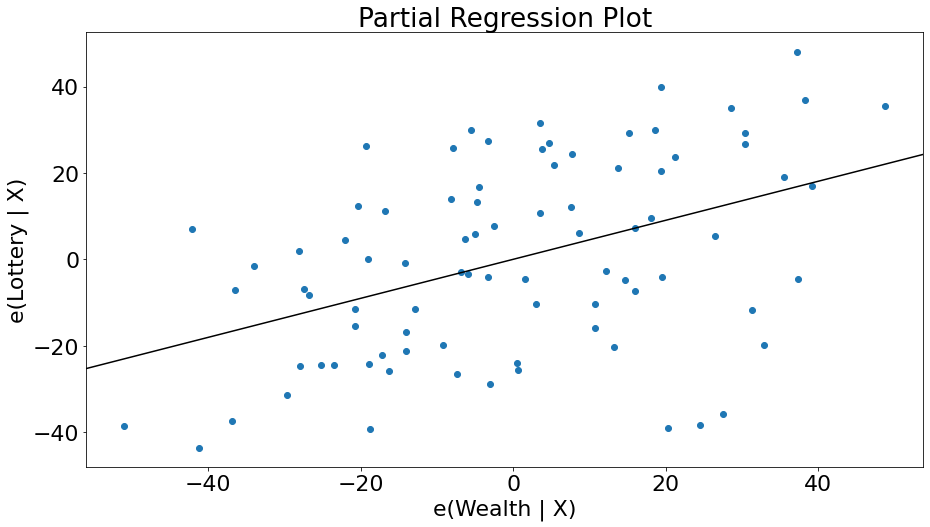

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

_ = sm.graphics.plot_partregress(
    'Lottery', 'Wealth', ['Region', 'Literacy'],
   data=df, obs_labels=False, ax=ax
)

eval_env: 1


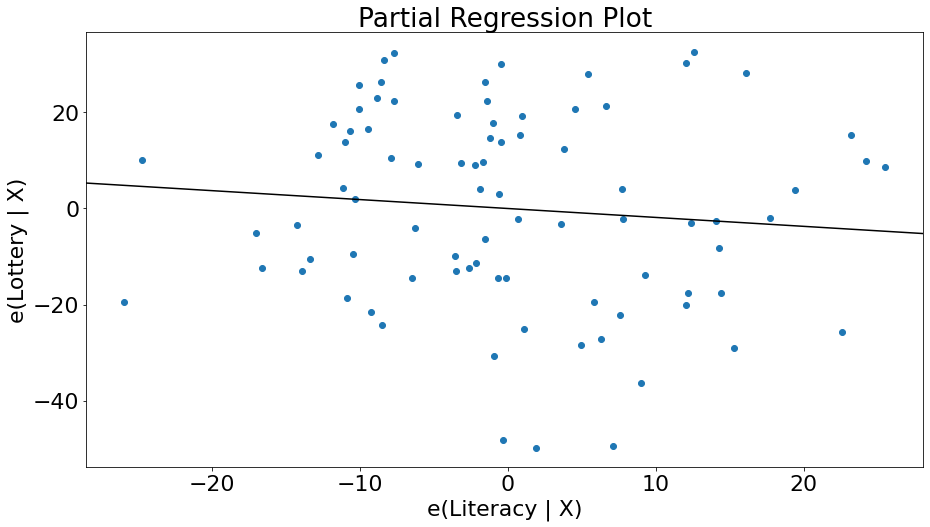

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

_ = sm.graphics.plot_partregress(
    'Lottery', 'Literacy', ['Region', 'Wealth'],
   data=df, obs_labels=False, ax=ax
)